### Setup

In [15]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import style
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format
style.use("ggplot")

### Load Dataset and Randomization

In [2]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


### Preprocess Features

In [3]:
def preprocess_features(california_housing_dataframe):
    """Preprocess input features from California housing dataset.
    
    Args:
      california_housing_dataframe: A Pandas DataFrame containing data from California housing dataset.
    Returns:
      A DataFrame that contains the features to be used in model subsuming synthetic features.
    """
    # Multiple features
    selected_features = california_housing_dataframe[
        ["latitude",
         "longitude",
         "housing_median_age",
         "total_rooms",
         "total_bedrooms",
         "population",
         "households",
         "median_income"]
    ]
    processed_features = selected_features.copy()
    # Create synthetic feature.
    processed_features["rooms_per_person"] = (california_housing_dataframe["total_rooms"]/california_housing_dataframe["population"])
    return processed_features

### Preprocess Targets

In [4]:
def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing dataset.
    
    Args:
      california_housing_dataframe: A Pandas DataFrame containing data from California housing dataset.
    Returns:
      A DataFrame that contains the target features.
    """
    output_targets = pd.DataFrame()
    # Scale the targets to be in units of thousands of dollars.
    output_targets["median_house_value"] = (california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

### Prepare Training and Target examples

In [5]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2630.7,536.5,1426.1,499.0,3.9,2.0
std,2.1,2.0,12.6,2124.6,408.2,1128.6,373.5,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1456.8,296.0,789.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2127.0,435.0,1167.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3160.2,650.0,1721.2,605.0,4.8,2.3
max,42.0,-114.3,52.0,32054.0,5290.0,35682.0,5050.0,15.0,55.2


In [6]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,207.2
std,115.7
min,15.0
25%,119.3
50%,180.2
75%,265.0
max,500.0


### Prepare Validation set

In [7]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.7,2674.7,546.4,1438.0,506.5,3.9,2.0
std,2.2,2.0,12.5,2307.4,451.9,1193.0,409.7,1.9,1.1
min,32.5,-124.3,1.0,11.0,3.0,8.0,2.0,0.5,0.2
25%,33.9,-121.8,18.0,1471.0,299.0,791.0,282.8,2.6,1.5
50%,34.3,-118.5,29.0,2127.0,431.0,1166.0,407.5,3.6,1.9
75%,37.7,-118.0,37.0,3127.0,646.0,1720.0,606.0,4.8,2.3
max,42.0,-114.6,52.0,37937.0,6445.0,28566.0,6082.0,15.0,34.2


In [8]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,207.5
std,116.6
min,25.0
25%,120.0
50%,180.5
75%,265.0
max,500.0


### Plot Latitude/Longitude vs. Median House Value

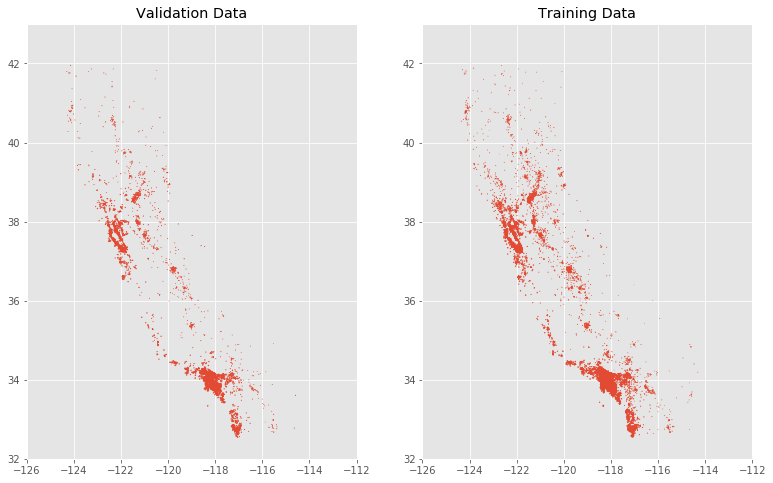

In [9]:
plt.figure(figsize=(13, 8))

ax1 = plt.subplot(1, 2, 1)
ax1.set_title("Validation Data")
ax1.set_autoscaley_on(False)
ax1.set_ylim([32, 43])
ax1.set_autoscalex_on(False)
ax1.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
            validation_examples["latitude"],
            validation_targets["median_house_value"]/validation_targets["median_house_value"].max())

ax2 = plt.subplot(1, 2, 2)
ax2.set_title("Training Data")
ax2.set_autoscaley_on(False)
ax2.set_ylim([32, 43])
ax2.set_autoscalex_on(False)
ax2.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            training_targets["median_house_value"]/training_targets["median_house_value"].max())
_ = plt.plot()

### Input Function

In [10]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = {key: np.array(value) for key, value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

### Construct Feature Columns

In [11]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.

    Args:
      input_features: The names of the numerical input features to use.
    Returns:
      A set of feature columns
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

### Train Model

In [12]:
def train_model(learning_rate,
                steps,
                batch_size,
                training_examples,
                training_targets,
                validation_examples,
                validation_targets):
    periods = 10
    step_per_period = steps / periods
    
    # Create a linear_regressor object and configure it
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns = construct_feature_columns(training_examples),
        optimizer = my_optimizer
    )
    
    # Create input_fns
    training_input_fn = lambda: my_input_fn(training_examples,
                                            training_targets["median_house_value"],
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples,
                                                    training_targets["median_house_value"],
                                                    shuffle=False,
                                                    num_epochs=1)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples,
                                                      validation_targets["median_house_value"],
                                                      shuffle=False,
                                                      num_epochs=1)
    
    # Train the model in loop of periods
    # loss metrics
    print("Training model...")
    print("  RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range(0, periods):
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = step_per_period
        )
        
        # Predictions of training and validation
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions,
                                                                                training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions,
                                                                                  validation_targets))
        print("    Period %02d : %0.2f" % (period+1, training_root_mean_squared_error))
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training", color='magenta')
    plt.plot(validation_rmse, label="validation", color='g')
    plt.legend()
    return linear_regressor

Training model...
  RMSE (on training data):
    Period 01 : 217.27
    Period 02 : 200.14
    Period 03 : 185.15
    Period 04 : 174.70
    Period 05 : 168.47
    Period 06 : 166.06
    Period 07 : 164.86
    Period 08 : 164.72
    Period 09 : 164.91
    Period 10 : 165.61
Model training finished.


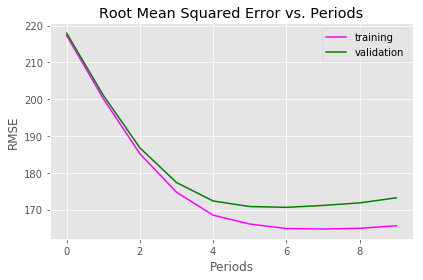

In [13]:
linear_regressor = train_model(
    learning_rate = 0.00003,
    steps = 500,
    batch_size = 5,
    training_examples = training_examples,
    training_targets = training_targets,
    validation_examples = validation_examples,
    validation_targets = validation_targets
)

### Testing the model

In [14]:
test_dataset = pd.read_csv("california_housing_test.csv", sep=",")

test_examples = preprocess_features(test_dataset)
test_targets = preprocess_targets(test_dataset)

predict_test_input_fn = lambda: my_input_fn(
    test_examples,
    test_targets,
    shuffle = False,
    num_epochs = 1
)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

test_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
print("Final RMSE (on test data): %0.2f" % test_root_mean_squared_error)

Final RMSE (on test data): 161.50
